### 1. Import corresponding modules

In [15]:
import obspy
import seispy
from seispy.decon import RFTrace

### 2. Read SAC files with 3 components (ENZ)
You should perpare teleseismic data if SAC format (ENZ) and read them via obspy. To facilitate the follow-up, you'd better write positions of the station and the event into SAC header (i.e., `stla`, `stlo`, `evla`, `evlo` and `evdp`).

In [16]:
st = obspy.read('rf_example/*.101.*.SAC')

### 3. Pre-process for raw data
You should remove the mean offset and linear trend of the waveforms, then filtered them with a Butterworth bandpass filter in the range of 0.05–2 Hz. The figures show a comparison between the raw data and the data after pre-process

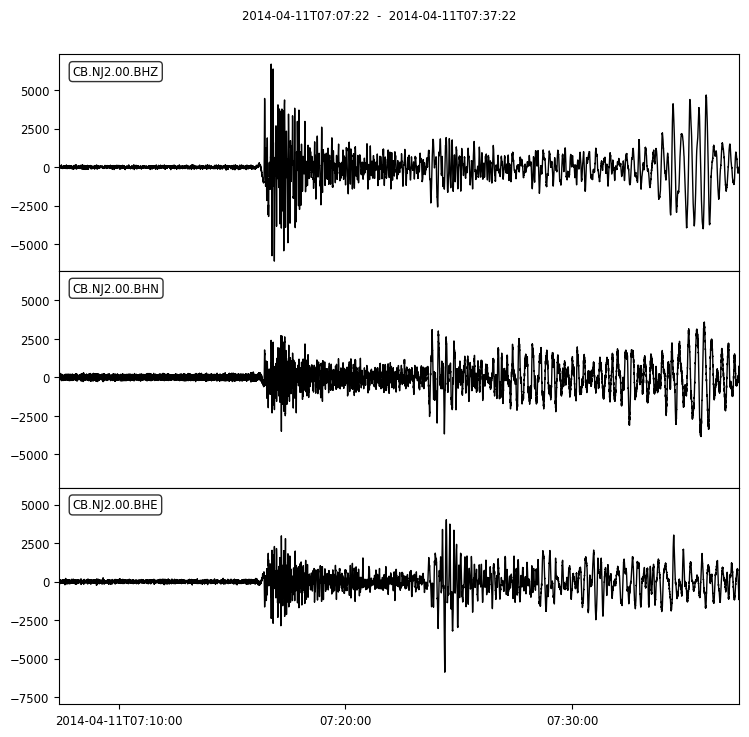

In [17]:
st_cmp = st.copy()

st.detrend()
st.filter("bandpass", freqmin=0.05, freqmax=2.0, zerophase=True)

# Plot for comparesion
st_cmp.plot()
st.plot()

### 4. Calculate the epicenter distance and back-azimuth
To trim the waveform or rotate the components, you can use the `seispy.distaz` to calculate the epicenter distance and back-azimuth.


In [18]:
da = seispy.distaz(st[0].stats.sac.stla, st[0].stats.sac.stlo, st[0].stats.sac.evla, st[0].stats.sac.evlo)
dis = da.delta
bazi = da.baz
ev_dep = st[0].stats.sac.evdp
print('Distance = %5.2f˚' % dis)
print('back-azimuth = %5.2f˚' % bazi)

Distance = 51.64˚
back-azimuth = 131.59˚


### 5. Rotation
Now you can rotate horizontal components (ENZ) into radial and transverse components (TRZ)

In [19]:
st_TRZ = st.copy().rotate('NE->RT', back_azimuth=bazi)

### 6. Estimating P arrival time and ray parameter by `obspy.taup`

In [20]:
from obspy.taup import TauPyModel

model = TauPyModel(model='iasp91')
arrivals = model.get_travel_times(ev_dep, dis, phase_list=['P'])
rayp = model.get_ray_paths(ev_dep, dis, phase_list=['P'])
P_arr = arrivals[0]
P_ray = rayp[0]

/home/xu_mijian/miniconda3/lib/python3.9/site-packages/obspy/taup/tau_branch.py:495: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


### 7.Trim the waveforms for PRF
Then you cut 130 s long waveforms around P arrival time (from 10 s before to 120 s after theoretical P arrival times).

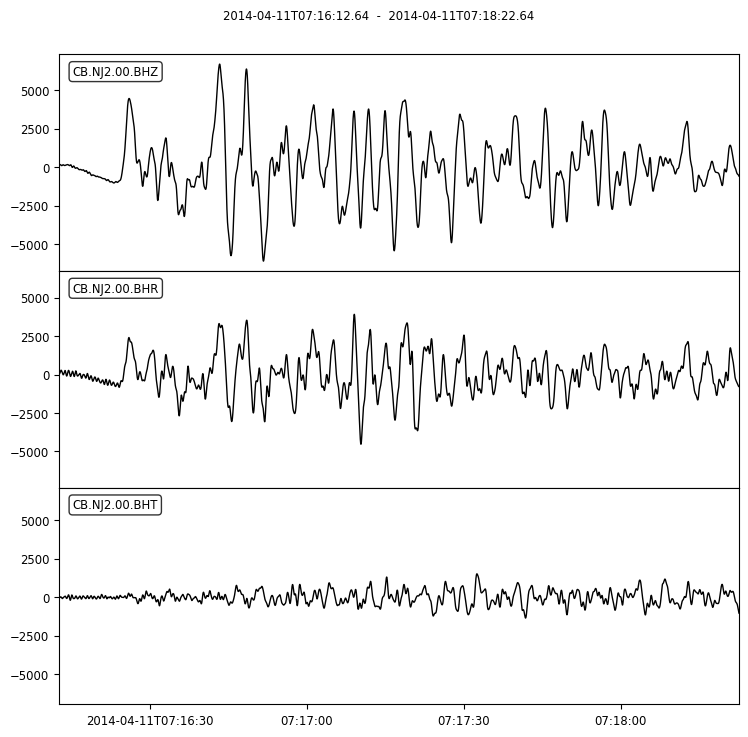

In [21]:
dt = st[0].stats.delta
shift = 10
time_after = 120

st_TRZ.trim(st_TRZ[0].stats.starttime+P_arr.time-shift,
            st_TRZ[0].stats.starttime+P_arr.time+time_after)

time_axis = st_TRZ[0].times() - shift
st_TRZ.plot(show=False)

### 8. Calculate PRF
`seispy.decov.decovit` provide a function with an iterative time-domain deconvolution method. Now let's Calculate a PRF. In this example we assume:
- Gauss factor = 2.0
- The maximum number of iterations = 400
- Minimum error = 0.001

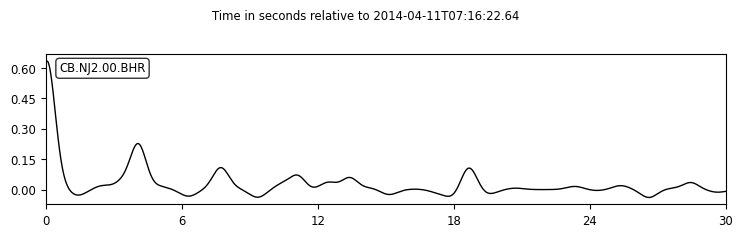

In [23]:
f0 = 2.0
itmax = 400
minderr = 0.001

rf = RFTrace.deconvolute(st_TRZ[1], st_TRZ[2], method='iter',
                         tshift=shift, f0=f0, itmax=itmax, minderr=minderr)
rf.plot(show=False, type='relative',
        starttime=rf.stats.starttime+shift,
        endtime=rf.stats.starttime+shift+30)